In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn import datasets
import pandas as pd

# Load the train and test data

In [11]:
df_train = pd.read_csv("train_data.txt", sep=" ", names=["col1", "col2", "col3"])
df_test = pd.read_csv("test_data.txt", sep=" ", names=["col1", "col2", "col3"])

In [12]:
df_train.head()  # sanity check

,col1,col2,col3
0,-4.072524,-9.577501,0.0
1,-3.591656,-4.651351,2.0
2,-1.621404,-10.069722,0.0
3,-2.352587,-9.027460,0.0
4,1.690682,-0.521923,1.0


In [13]:
df_test.head()  # sanity check

,col1,col2,col3
0,-0.577060,-9.426309,0.0
1,-2.289926,-9.661375,0.0
2,-1.724228,-3.966204,2.0
3,-4.080085,-9.351840,0.0
4,2.143670,-1.731809,1.0


In [14]:
x_train = df_train[["col1", "col2"]].astype(np.float32).values
y_train = df_train["col3"].astype(np.float32).values
x_test = df_test[["col1", "col2"]].astype(np.float32).values
y_test = df_test["col3"].astype(np.float32).values

# Question 3 [60 points]: Linear Classifier Implementations 

a) [35 points: 15 points for each model, 5 points for evaluation] Using the provided dataset in the notebook, implement the perceptron and linear discriminant analysis (LDA) algorithms (use NumPy, Pandas) to classify the dataset. Then, report the accuracy of trained models. 

In [27]:
class Perceptron:
  
  def __init__ (self):
    self.w = None
    self.threshold = None
    
  def model(self, x):
    #Return 1 if (w*x) greater than or equal to threshold - Else return 0.
    result = np.where(self.w.T @ x >= self.threshold, 1, 0)

    return np.squeeze(result)
  
  def predict(self, X):
    #Predict values for the input X using the 'model' function above and store it in Y
    Y = self.model(X)
    return np.array(Y)
    
  def fit(self, X, Y, epochs = 1, lr = 1):

    self.w = np.zeros(X.shape[1]).reshape(-1, 1)
    self.threshold = 0

    accuracy = {}
    max_accuracy = 0
    wt_matrix = []

    for i in range(epochs):
      for x, y in zip(X, Y):
        y_pred = self.predict(x.reshape(-1, 1))

        if y == 1 and y_pred == 0:
          #Update the w and threshold
          self.w = self.w + (lr * x.T.reshape(-1, 1)) * y
          # TODO: do I need to update the threshold here also?
      
        elif y == 0 and y_pred == 1:
          # modify this part
          self.w = self.w - (lr * x.T.reshape(-1, 1))
          
      wt_matrix.append(self.w)    
      accuracy[i] = accuracy_score(self.predict(X.T), Y)
      if (accuracy[i] > max_accuracy):
        max_accuracy = accuracy[i]
        chkptw = self.w
        chkptb = self.threshold
    #checkpoint (Save the best weights and b value)
    self.w = chkptw.reshape(-1, 1)
    self.threshold = chkptb
        
    print(max_accuracy)
    #plot the accuracy values over epochs
    plt.plot(accuracy.values())
    plt.xlabel("Epoch #")
    plt.ylabel("Accuracy")
    plt.ylim([0, 1])
    plt.show()
    
    #return the weight matrix, that contains weights over all epochs
    return np.array(wt_matrix)


0.58


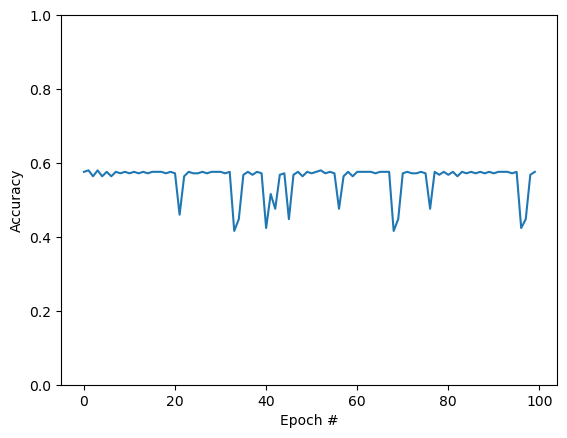

In [28]:
perceptron = Perceptron()

wt_matrix = perceptron.fit(x_train, y_train, 100, 0.001)

In [29]:
#Report the test accuracy for Perceptron. 
score = accuracy_score(perceptron.predict(x_test.T), y_test)
print(f"Test Accuracy: {round(score * 100, 2)}%.")

Test Accuracy: 58.73%.


In [ ]:
import numpy as np

class LDA:

    def __init__(self, n_components):
        self.n_components = n_components
        self.linear_discriminants = None

    def fit(self, X, y):
  

    def transform(self, X):
        # project data

b)	[5 points] Use the provided test dataset, general and evaluate the models. 

c)	[15 pts] Implement models (perceptron, LDA, and logistic regression) using Scikit-learn. 

d)	[5 points] Compare the weights obtained and the accuracies of trained models. Did you expect weights to be the same? Explain why or why not? 

# Question 4 [20 points]: Linear Regression and regularization

Suppose we decided to reject the linear model for the housing dataset discussed in linear regression lecture (the second model with all features after the preprocessing). Then, we are going to implement a new model that is less complex (lower number of features) and outperform (lower RMSE). 

a)	[10 points] Retrain the dataset. In the new trained dataset, same feature engineering for the continuous features is not allowed while the discrete features may be used as they are. For each process, explain explicitly the reason of work. 

b)	[10 points] Suppose the worst scenario is when the RMSE of new model is higher but within 5% with the same number of features that the original model had. Train five different models (with or without regularizations) and report the results. Select the best model among five models and explain why. 